# Effect of straylight subtraction on MRS extended source observations
The third calibration step in the baseline MRS calibration pipeline (after assigning WCS information and applying the pixel flat), is the straylight subtraction. This step comes before the fringe correction and the flux calibration.  
  
In this notebook we use the method of straylight subtraction (version 2) developed by Adrian Glauser and Polychronis Patapis at ETH Zurich (see MIRI-TN-00003-ETH-1.0_MRS_straylight). We check what the impact of the correction is on data of an 800K BB extended source observed during testing carried out at RAL (MIRI FM test campaign).

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [26]:
# import modules
import funcs
import mrsobs

from numpy import (where,diff)
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

We load an MRS image of a optical stimulus observed in one of the MRS nominal spectral bands. In this case the source is the:  
* MTS 800K BB extended source, observed in spectral bands 1A/2A

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band     = '1A'
ext_source_sci,ext_source_bkg = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')
et_ext_source_sci,et_ext_source_bkg = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1A')

# load detector2cube (d2c) distortion maps
d2cMaps  = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir) # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta, and wavelength coordinates
sliceMap = d2cMaps['sliceMap']     # map with slice IDs
det_dims = (1024,1032)             # pixel dimensions of the detector

We subtract background exposures (if available).

In [3]:
ext_source_bkgsubtr = ext_source_sci-ext_source_bkg
et_ext_source_bkgsubtr = et_ext_source_sci-et_ext_source_bkg

<IPython.core.display.Javascript object>


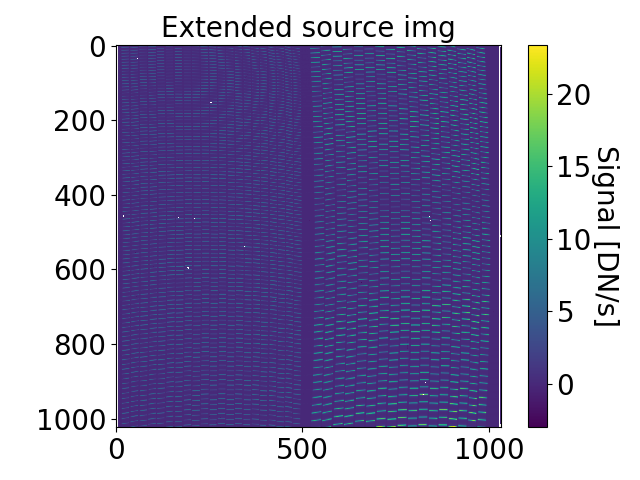

In [4]:
fig = plt.figure()
p = plt.imshow(et_ext_source_bkgsubtr)
plt.title("Extended source img")
cbar = fig.colorbar(p)
cbar.set_label('Signal [DN/s]', labelpad=20,rotation=270)
plt.tight_layout()

The straylight flux signal "s" in science pixels is inferred from the pixels $p_i$ in the low-signal space between the high-signal vertical slices. The straylight signal is inverse-distance weighted using Shepard's method (Shepard, Donald (1968), "A two-dimensional interpolation function for irregularly-spaced data", Proceedings of the 1968 ACM National Conference, pp. 517–524). Mathematically:  
$$  
s=\frac{\sum p_{i}\cdot w_{i}}{\sum w_i}  
$$
 
where the weight coefficients $w_i$ are given by  
$$
w_{i}=\left(\frac{max(0,R−d_{i})}{R\cdot d_{i}}\right)^k  
$$  
  
where $d_{i}$ is the distance to the science pixels within a radius R. The exponent k is set equal to 1.

<IPython.core.display.Javascript object>


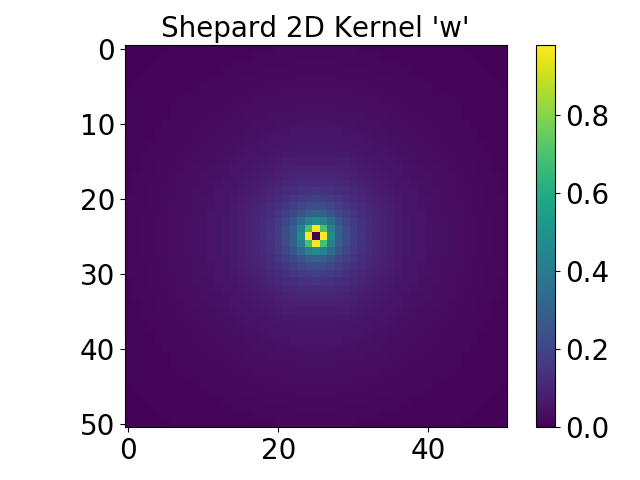

In [5]:
w   = funcs.Shepard2DKernel(50,1)
fig = plt.figure()
p   = plt.imshow(w)
fig.colorbar(p)
plt.title("Shepard 2D Kernel 'w'")
plt.tight_layout()

<IPython.core.display.Javascript object>


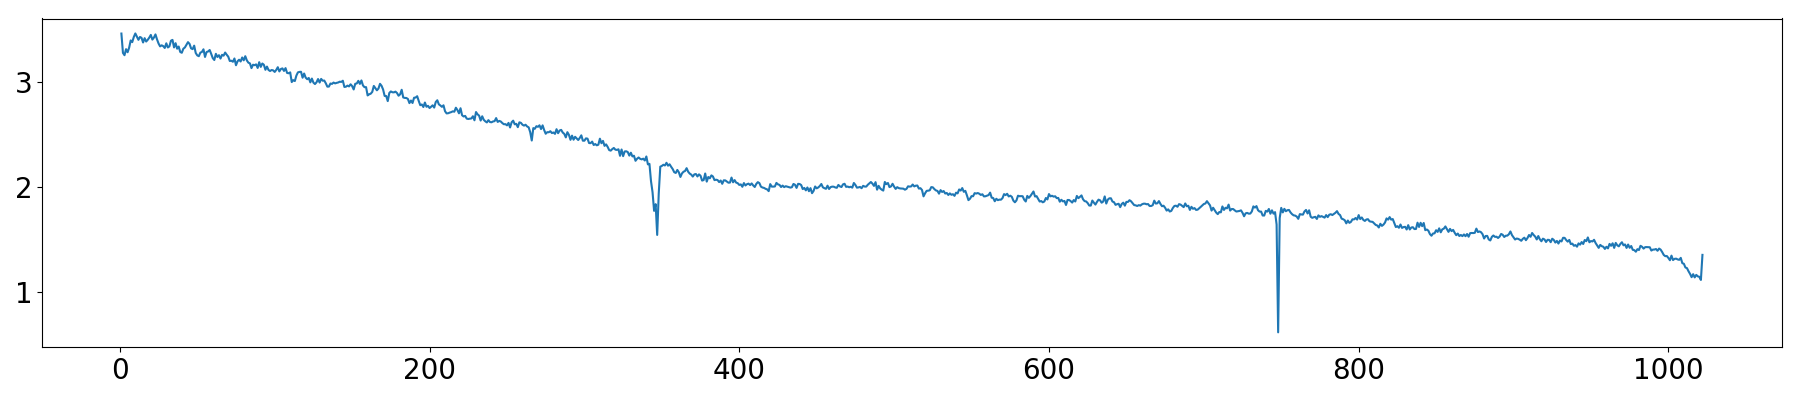

<IPython.core.display.Javascript object>


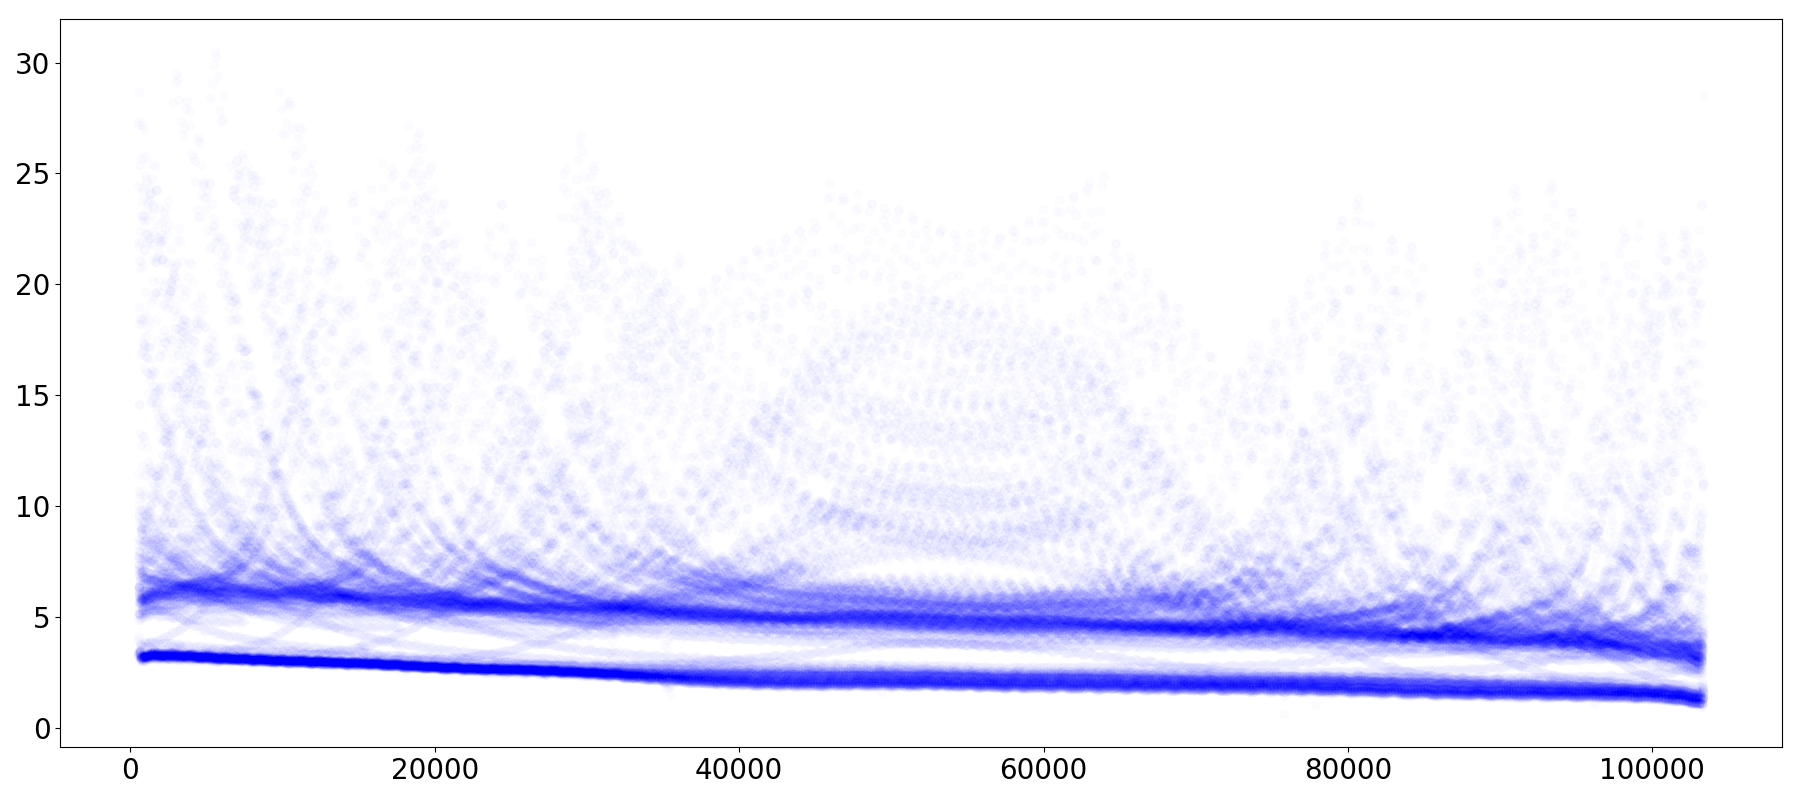

In [110]:
#mask where gap pixels are 1 and slice pixels are 0
mask = np.zeros_like(sliceMap)
mask[sliceMap == 0] = 1

#apply mask to science img
img_gap = ext_source_bkgsubtr*mask

# plt.figure(figsize=(18,8))
# plt.imshow(img_gap,vmin=0,vmax=20)
# plt.tight_layout()

plt.figure(figsize=(18,4))
plt.plot(img_gap[:,512])
plt.tight_layout()

sel = np.where(img_gap[:,:517]<3.56)
validMap = np.zeros((1024,1032))
validMap[np.where(img_gap[:,:517]<3.56)] = 1

img = img_gap[:,:517].copy()
img[(img_gap[:,:517]>3.56)] = 0

# plt.figure(figsize=(18,8))
# plt.imshow(img)
# plt.tight_layout()

test = img_gap[:,:517][np.nonzero(img_gap[:,:517])]
test2 = img_gap[:,:517][sel][np.nonzero(img_gap[:,:517][sel])]
test3 = img_gap[:,26:490][np.nonzero(img_gap[:,26:490])]

plt.figure(figsize=(18,8))
plt.plot(np.arange(len(test)),test,'bo',alpha=0.01)
# plt.plot(np.arange(len(test2)),test2,'bo',alpha=0.2)
# plt.plot(np.arange(len(test3)),test3,'bo',alpha=0.05)
plt.tight_layout()

# img_gap[img_gap>0.02*np.max(sci_img[sliceMap>0])] = 0 # avoid cosmic rays contaminating result
# img_gap[img_gap<0] = 0 # set pixels less than zero to 0
# img_gap = convolve(img_gap, Box2DKernel(3)) # smooth gap pixels with Boxkernel
# img_gap*=mask # reset sci pixels to 0
# # convolve gap pixel img with weight kernel
# astropy_conv = convolve(img_gap, w)
# # normalize straylight flux by sum of weights
# norm_conv = convolve(mask, w)
# astropy_conv /= norm_conv
# # reinstate gap pixels to previous values
# #astropy_conv[sliceMap==0] = img_gap[sliceMap==0]
# return sci_img-astropy_conv

<IPython.core.display.Javascript object>


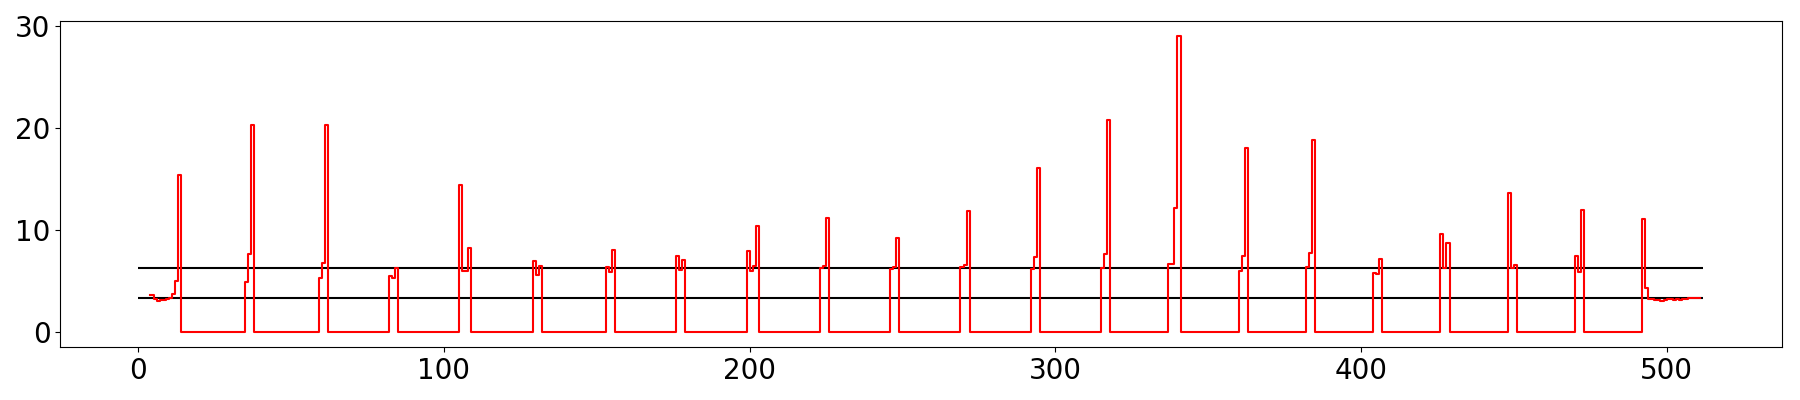

<IPython.core.display.Javascript object>


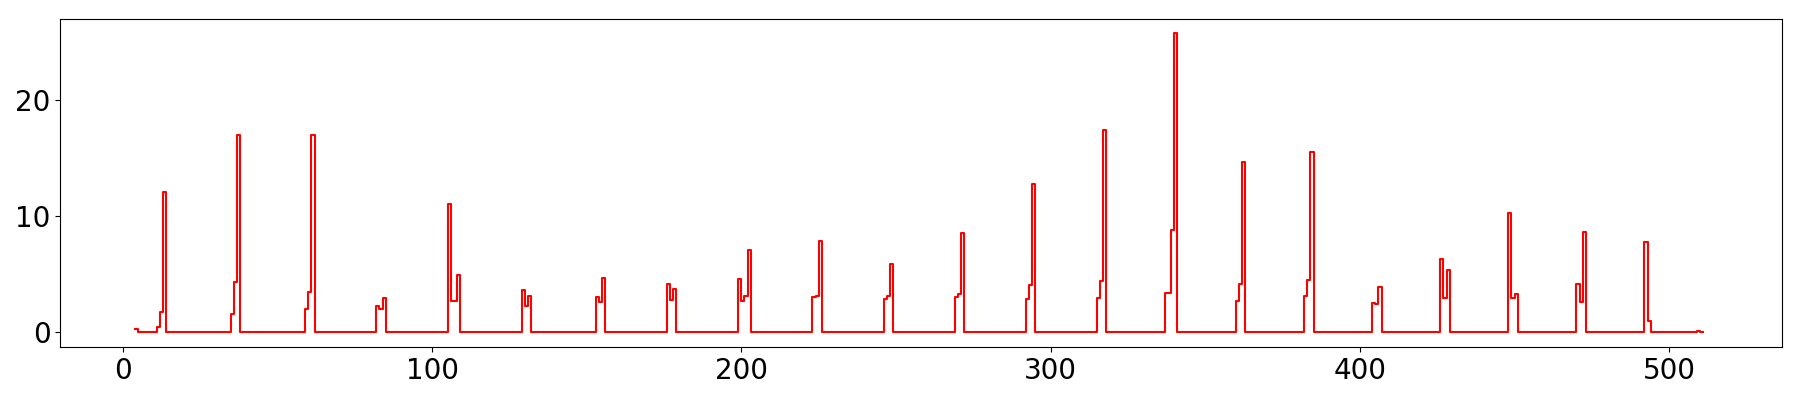

In [63]:
# plt.figure(figsize=(18,4))
# plt.plot(img_gap[:,5:10],'r')
# plt.plot(img_gap[:,510:514],'k')
# plt.plot(img_gap[:,1010:],'b')
# plt.tight_layout()

plt.figure(figsize=(18,4))
plt.step(img_gap[24,:512],'r')
plt.hlines(3.33,0,512)
plt.hlines(6.33,0,512)
plt.tight_layout()

new_img_gap = img_gap[24,:512]-3.33
new_img_gap[(new_img_gap<0)] = 0

plt.figure(figsize=(18,4))
plt.step(new_img_gap,'r')
plt.tight_layout()

## Test 1: Calculate the amount of straylight
We use the input parameters designated in MIRI-TN-00003-ETH-1.0_MRS_straylight as being "optimal" to estimate the amount of straylight in an image.

In [6]:
ext_straylight = ext_source_bkgsubtr-funcs.straylightCorrection(ext_source_bkgsubtr,sliceMap,R=50, k=1)
et_ext_straylight = et_ext_source_bkgsubtr-funcs.straylightCorrection(et_ext_source_bkgsubtr,sliceMap,R=50, k=1)

<IPython.core.display.Javascript object>


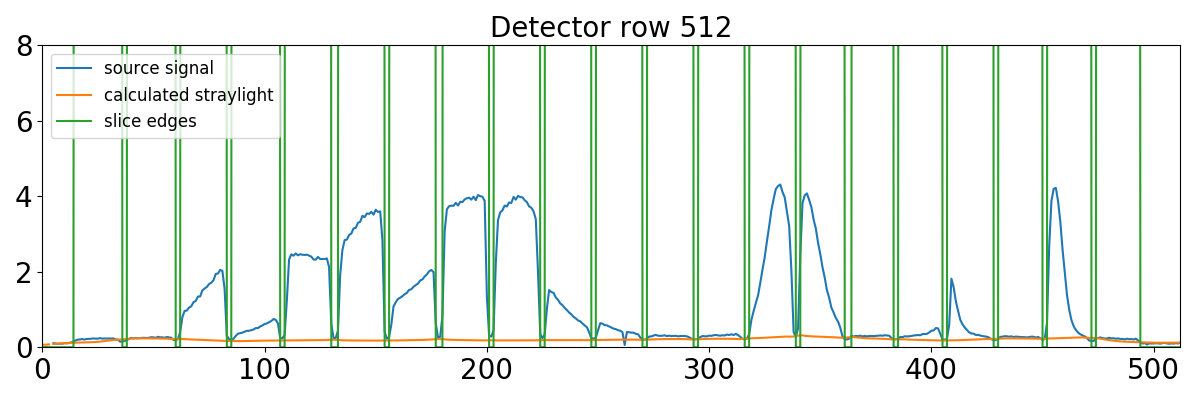

<IPython.core.display.Javascript object>


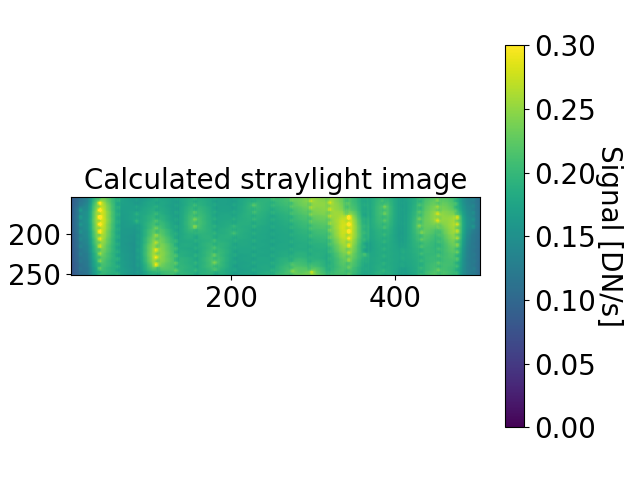

In [64]:
xcol = 50
plt.figure(figsize=(12,4))
plt.title('Detector row 512')
plt.plot(et_ext_source_bkgsubtr[xcol,:],label='source signal')
plt.plot(et_ext_straylight[xcol,:],label='calculated straylight')
plt.plot(sliceMap[xcol,:],label='slice edges')
plt.xlim(0,512)
plt.ylim(0,8)
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

fig = plt.figure()
p = plt.imshow(et_ext_straylight,interpolation='None',vmin=0,vmax=0.3)
plt.title("Calculated straylight image")
cbar = fig.colorbar(p)
cbar.set_label('Signal [DN/s]', labelpad=20,rotation=270)
plt.tight_layout()

## Remarks:
* The computed straylight appears to have some structure to it. More importantly it appears that the structure is somehow related to the shape of the MRS slices.  
  
Let's overplot the slice map over the calculated straylight image.

<IPython.core.display.Javascript object>


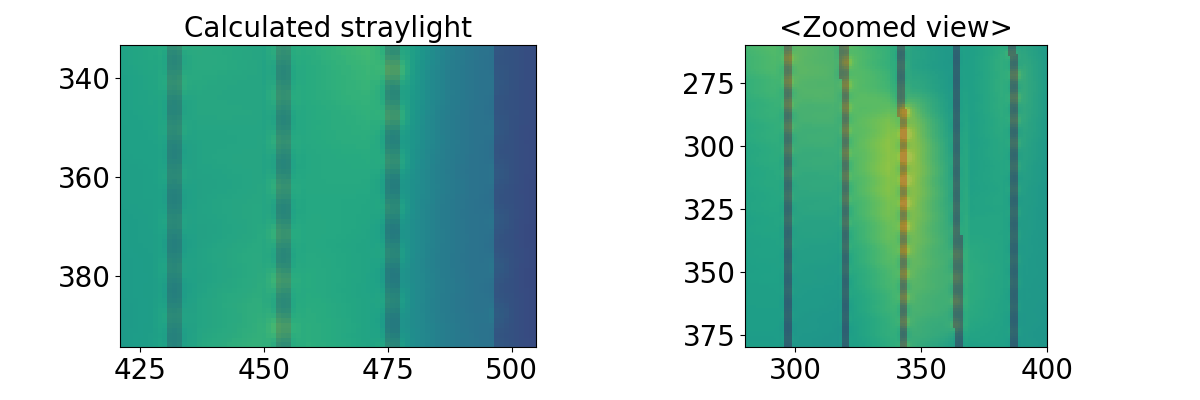

In [65]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].set_title("Calculated straylight")
axs[0].imshow(et_ext_straylight,interpolation='None',vmin=0,vmax=0.3)
axs[0].imshow(sliceMap,alpha=0.2)
axs[1].set_title("<Zoomed view>")
axs[1].imshow(et_ext_straylight,vmin=0,vmax=0.3,interpolation='None',zorder=0)
axs[1].imshow(sliceMap,alpha=0.4,zorder=1)
axs[1].set_xlim(280,400)
axs[1].set_ylim(380,260)
plt.tight_layout()

## Remarks:
* What exactly is happening? We see that, when close to a MRS slice corner, the estimated straylight signal is higher. Given that the straylight estimation algorithm uses the MRS d2c slice map, what we see actually makes sense. Pixels that have high signal, but which are omitted from being "science" pixels, amplify the estimation of the straylight. One could argue that this is correct, and that the straylight is genuinely higher at that location, however this can only be an erroneous conjecture. There is a clear link between what we measure, and the arbitrarily defined selection of which pixels count as science pixels and which count as non-science pixels.

## Test 2: What does the source spectrum look like in a detector pixel column that contains an MRS slice corner?

<IPython.core.display.Javascript object>


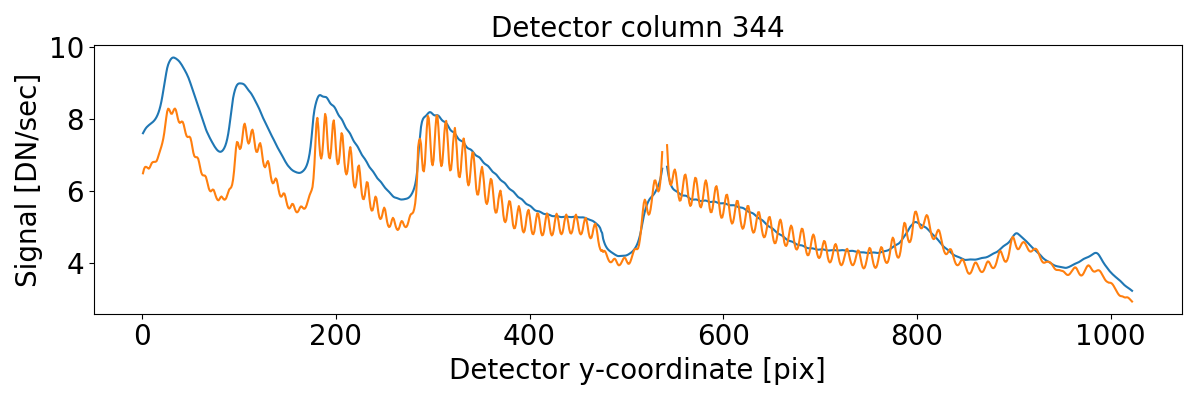

<IPython.core.display.Javascript object>


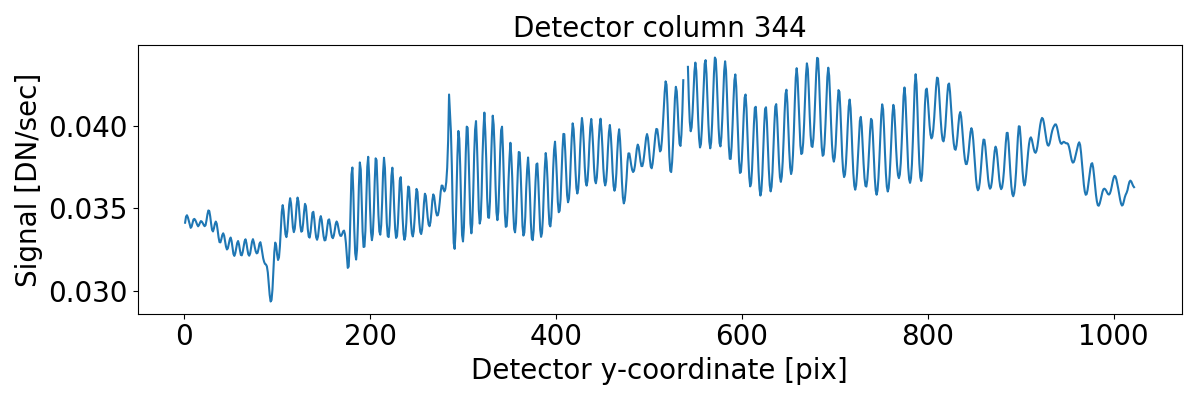

In [19]:
plt.figure(figsize=(12,4))
plt.plot(ext_straylight[:,344])
plt.plot(et_ext_straylight[:,344]*25.)
plt.xlabel('Detector y-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.title('Detector column 344')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(et_ext_straylight[:,344]/ext_straylight[:,344])
plt.xlabel('Detector y-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.title('Detector column 344')
plt.tight_layout()

## Remark:
* There is a systematic under/over-estimation of the straylight caused by the definition of the d2c slice map (itself "burdened" by the pixel discretization of the MRS images).  
  
How does the above spectrum change within a slice? Let's look at pixel traces within a slice, at different (constant) along-slice positions $\alpha$.

<IPython.core.display.Javascript object>


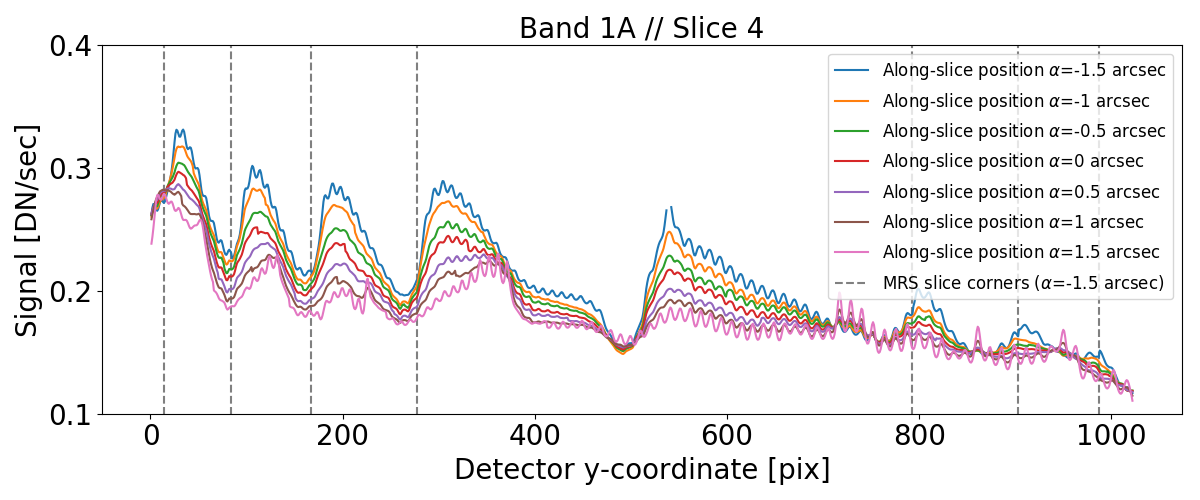

In [23]:
plt.figure(figsize=(12,5))
for alpha_pos in [-1.5,-1,-0.5,0,0.5,1,1.5]:
    ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=4,alpha_pos=alpha_pos)
    plt.plot(et_ext_straylight[ypos,xpos],label=r'Along-slice position $\alpha$={} arcsec'.format(alpha_pos))
    if alpha_pos == -1.5:
        plt.vlines(where(abs(diff(xpos))==1),0,0.4,'gray',linestyle='dashed',label=r'MRS slice corners ($\alpha$={} arcsec)'.format(alpha_pos))
plt.ylim(0.1,0.4)
plt.xlabel('Detector y-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.title('Band 1A // Slice 4')
plt.legend(loc='upper right',fontsize=12)
plt.tight_layout()

## Remarks:
* The straylight measure reduces the further one goes from (in this case) the left edge of the slice.
* In some places the straylight increases from the left edge of the slice to the right edge of the slice, such as at pixel 730, 860, and 950. It is expected that the same phenomenon we describe above for the "left side" is also applicable to the right edge of MRS slices (in the above situation the effect is less prominent).  
  
How does the straylight subtraction affect the scientific signal? Let's look at the ratio of the straylight signal and the scientific signal.

<IPython.core.display.Javascript object>


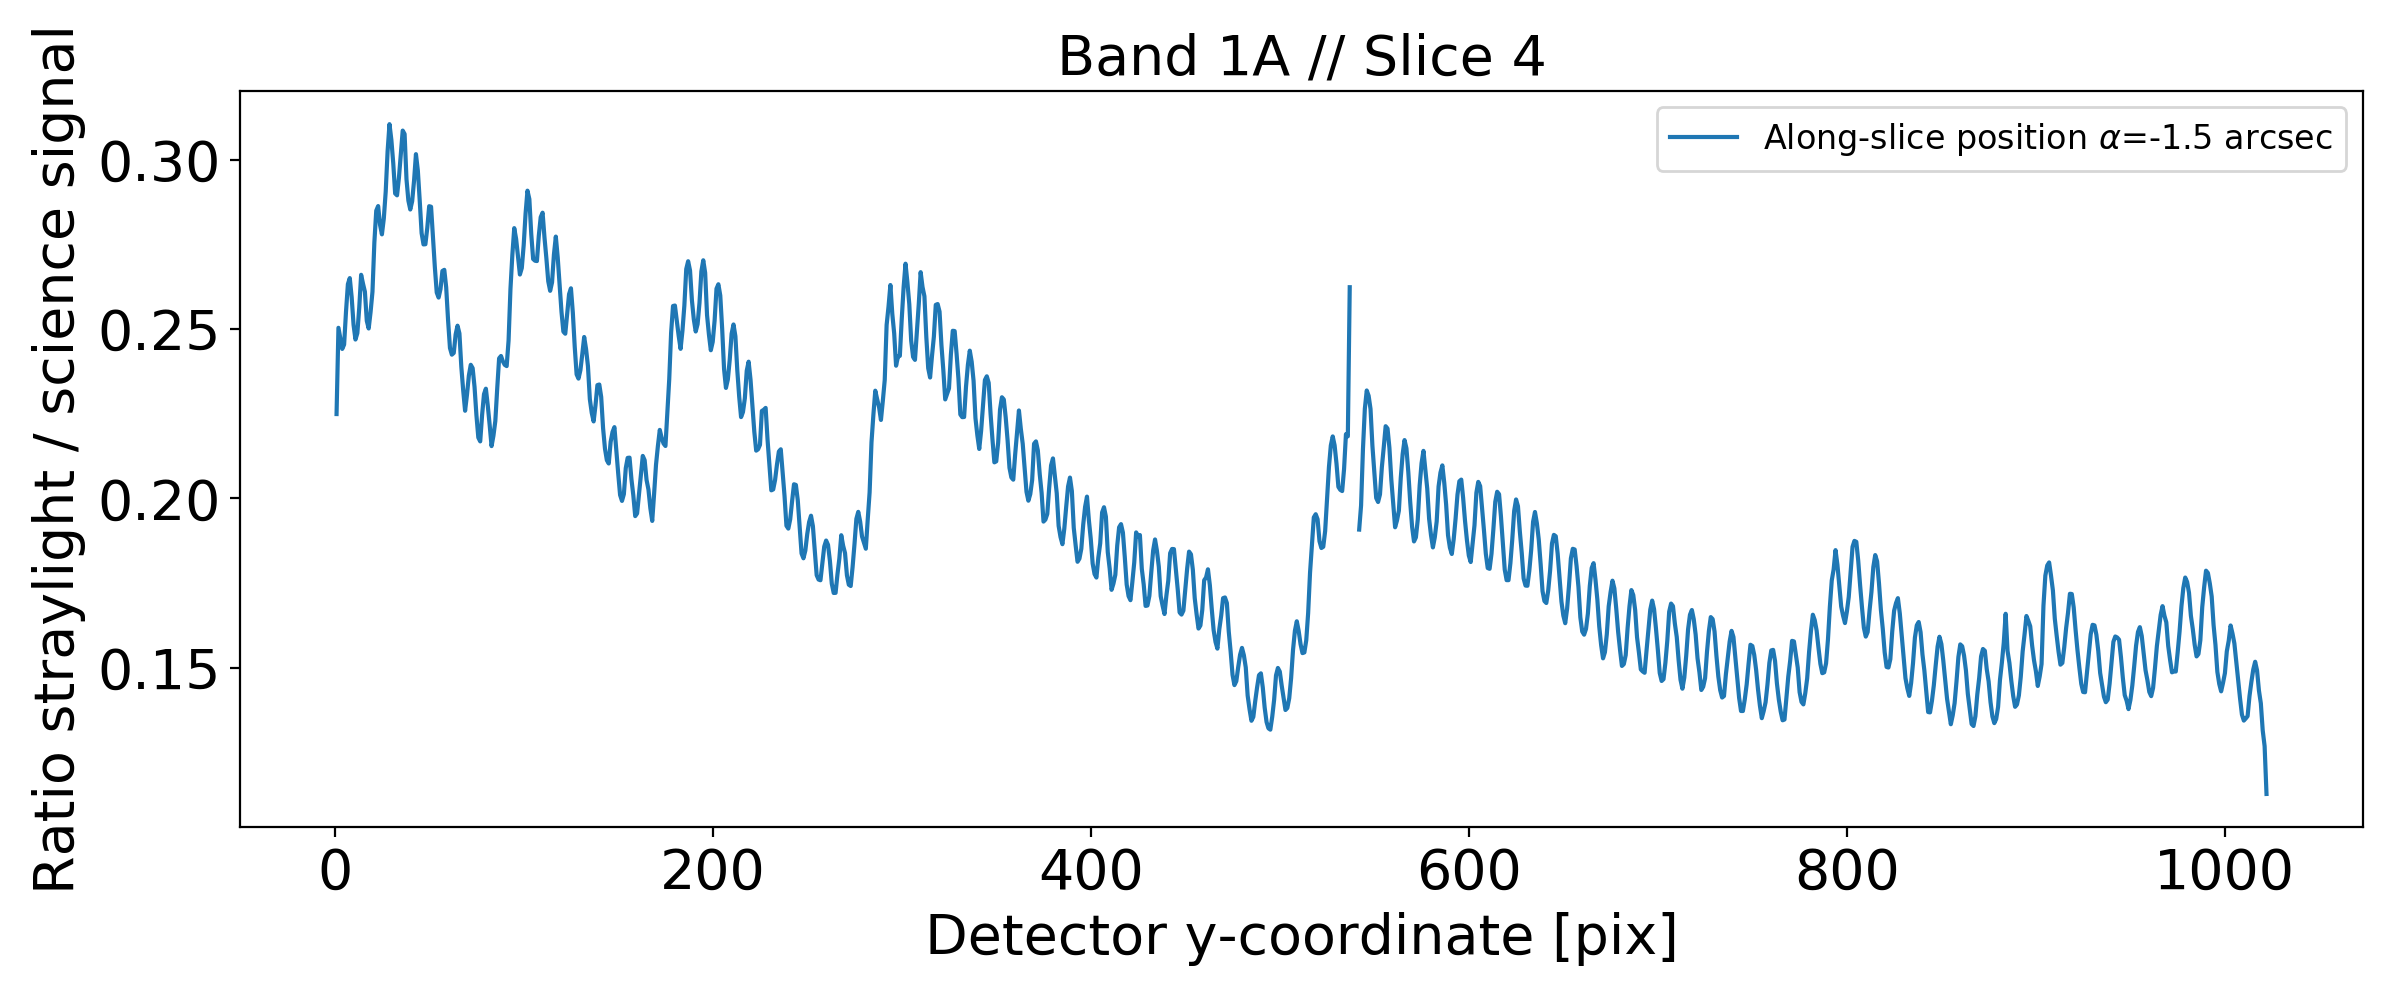

In [13]:
alpha_pos=-1.5
plt.figure(figsize=(12,5))
ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=4,alpha_pos=alpha_pos)
plt.plot(straylight[ypos,xpos]/ext_source_bkgsubtr[ypos,xpos],label=r'Along-slice position $\alpha$={} arcsec'.format(alpha_pos))
plt.xlabel('Detector y-coordinate [pix]')
plt.ylabel('Ratio straylight / science signal')
plt.title('Band 1A // Slice 4')
plt.legend(loc='upper right',fontsize=12)
plt.tight_layout()

## Remarks:
* In the worst case scenario, from peak to peak, there is a 7% difference in the above-plotted ratio.
* Provided that the straylight subtraction step is used to determine the spectral response of the MRS, a systematic error will be introduced in the response (systematic related to the d2c slice map).
* The MIRI MRS calibration procedure is bound to the hip with the fringing produced in the detector setup. The calculated straylight does not show fringing. This is both due to the fact that the straylight estimation algorithm cannot resolve high-frequency patterns, but also due to the fact that straylight is not expected to produce fringes. The reasoning behind the latter statement lies in the fact that straylight is expected to be "gray" (i.e. spectrally and spatially unresolved).  
  
Although the straylight does not seem to contain the signature of MIRI detector fringing, the systematic error in its determination does manifest as a low-frequency fluctuation in signal. One of the fringing components identified in the MRS spectra is a low-frequency fringe caused by internal reflection in one of the detector optical layers. How does the systematic error in the straylight affect the low-frequency fringe signature?

## Test 3: Effect of straylight correction on MRS spectral fringing

<IPython.core.display.Javascript object>


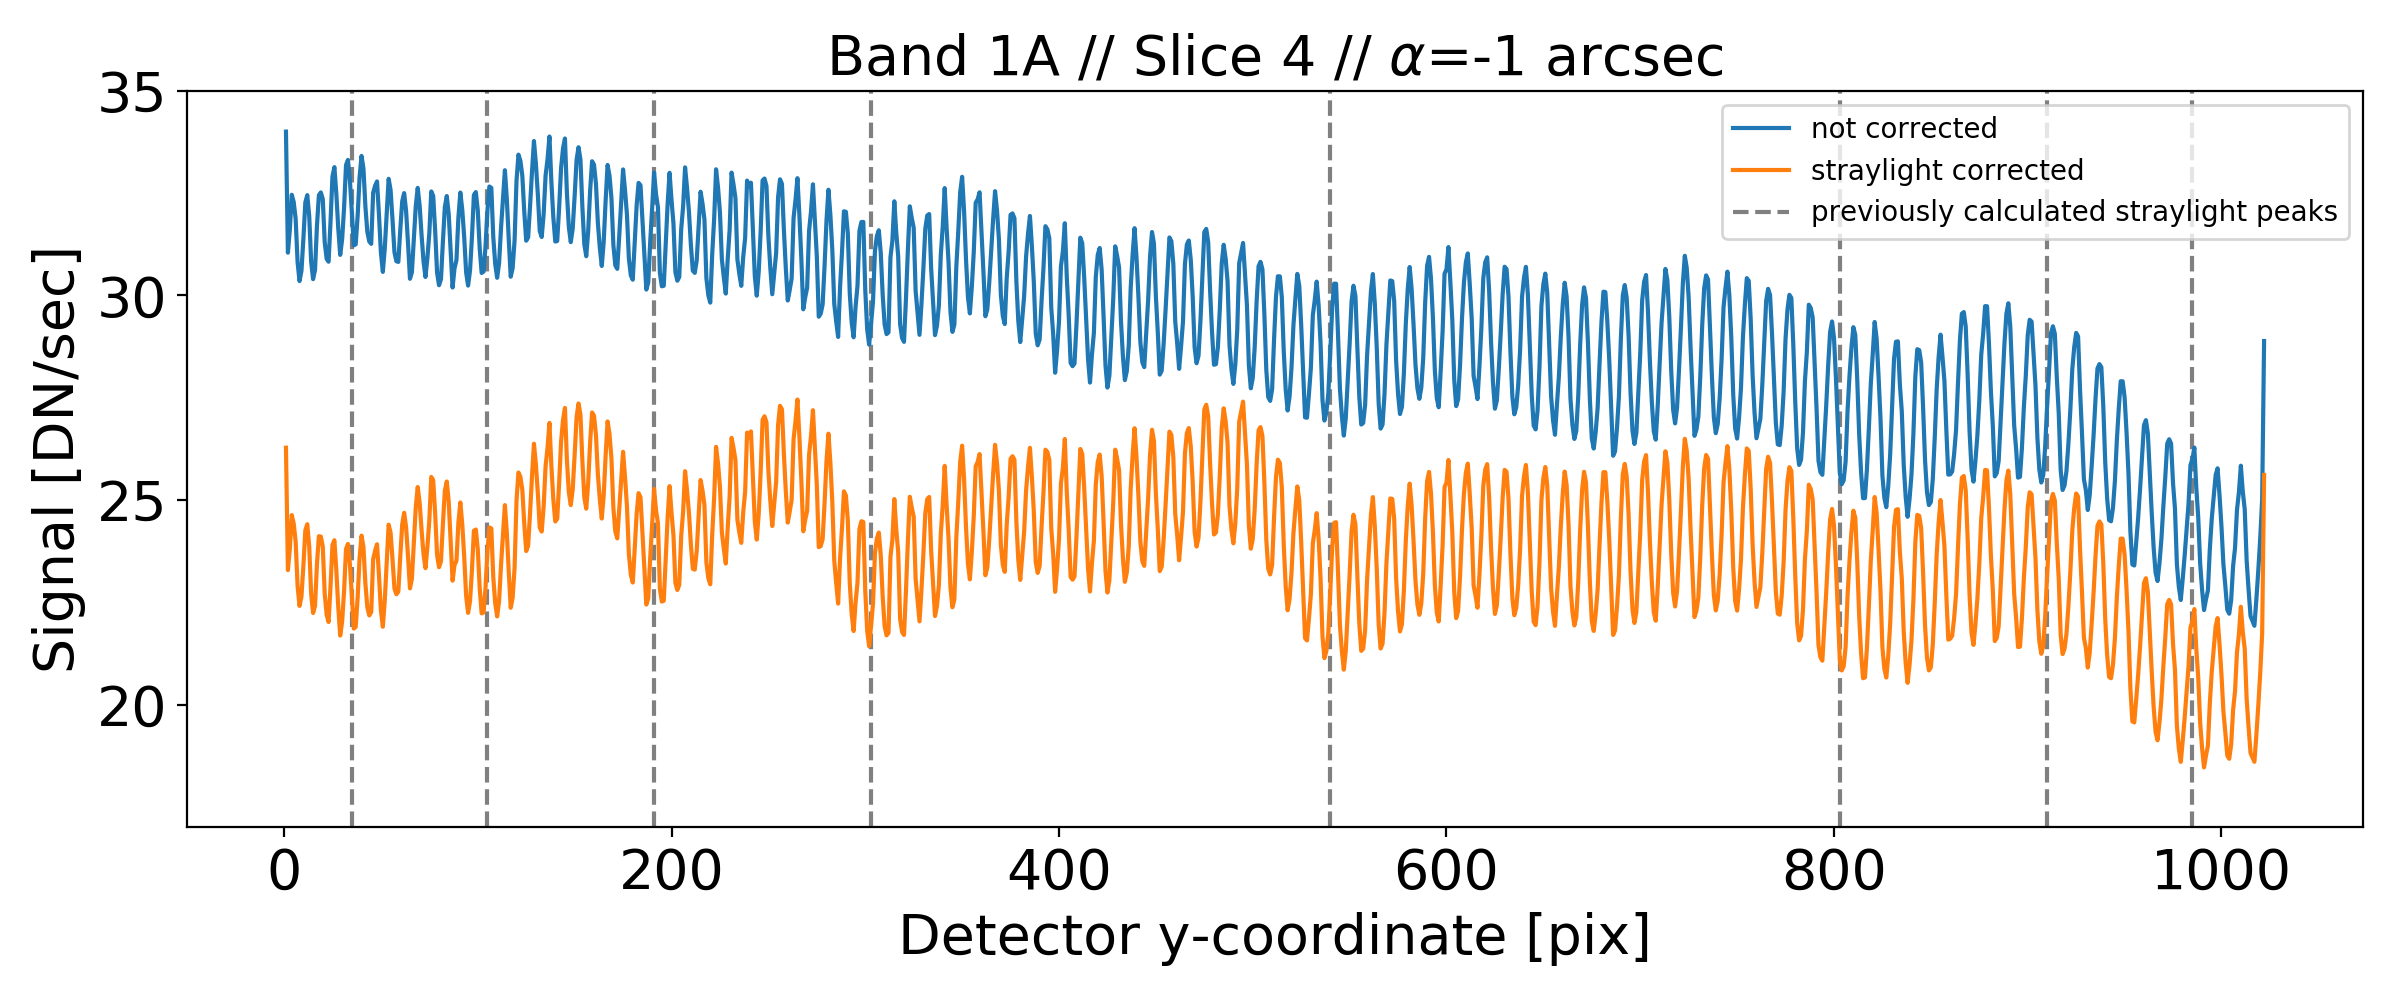

In [14]:
alpha_pos=-1
plt.figure(figsize=(12,5))
ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=4,alpha_pos=alpha_pos)
plt.plot(ext_source_bkgsubtr[ypos,xpos],label='not corrected')
plt.plot(ext_source_bkgsubtr[ypos,xpos]-straylight[ypos,xpos],label='straylight corrected')
plt.vlines([35,105,191,303,540,803,910,985],17,35,'gray',linestyle='dashed',label='previously calculated straylight peaks')
plt.ylim(17,35)
plt.xlabel('Detector y-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.title(r'Band 1A // Slice 4 // $\alpha$={} arcsec'.format(alpha_pos))
plt.legend(loc='upper right',fontsize=10)
plt.tight_layout()

## Remarks:
* The intrinsic low-frequency fringe in the not-straylight-corrected spectrum is disrupted by the straylight-subtraction.

# Conclusions:
* The third calibration step in the baseline MRS calibration pipeline (after assigning WCS information and applying the pixel flat), is the straylight subtraction. This step comes before the fringe correction and the flux calibration.
* Applying the current straylight algorithm (v2) yields a ratio between the scientific signal and the straylight signal of 20% (in MRS band 1A). Subtracting this "spurious" signal has an important impact on the scientific signal, and should thus be treated carefully.
* We notice that there is a systematic variation of the estimated straylight w.r.t. the detector2cube slice map. The cause is expected to be due to the selection of which detector pixels count as "science" pixels, and which count as "non-science" pixels. At locations where this distinction is not made carefully (due to the limitations imposed by the pixel discretization), the straylight signal is found to be larger than at other locations. This yields a systematic error w.r.t. the d2c slice map.
* The systematic error in the straylight determination propagates downward into the detector fringe correction and the flux calibration.

# Follow-up questions:
* How can this systematic error be mitigated/solved?
* There could be a magical combination for the input parameters of the straylight algorithm that fixes the problem, however (in my humble opinion) the underlying cause of this problem can hardly yield to such petty efforts. The dependency of the straylight algorithm on the d2c slice map needs to be leveraged.. (I don't know yet how)